In [2]:
import pandas as pd
import numpy as np
import csv
import os
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression  
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from scipy import stats
from math import sqrt
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [3]:
#Activate the first option if whole column width is necessary and the second to make all columns visible
#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)

## I. Import the dataset from V2

In [4]:
#Import the processed dataset from the V2 of this notebook
df = pd.read_csv('Det_curve_set1.csv', index_col = 0)
rci = pd.read_csv('RCI_ZScore_v1.csv', index_col = 0)
print(df.columns)
print(rci.columns)

C:\Users\J FernandezGomez\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Index(['feature_id', 'FinancialY', 'sub_obs_val_med', 'sub_obs_val_max',
       'sub_obs_val_std', 'Carriageway Scheme', 'Drainage', 'Drainage CAT 2',
       'Localised Patching', 'Long Term Structural Maintenance',
       'Major Patching', 'Microasphalt', 'Reconstruction', 'Recycling',
       'Super Cat 2', 'Surface Dressing', 'Surface Inlay', 'Surface Overlay',
       'Surface Preservative', 'Thin Surfacing', 'Years_since', 'CCD1', 'CCD3',
       'CCD4', 'CFL', 'CFS1', 'CKD2', 'CKD3', 'CMD3', 'CMUD', 'CPH2', 'CPH3',
       'CPH4', 'CPH7', 'CSH1', 'DCF1', 'DCF2', 'DCF3', 'DPD1', 'DPD2', 'GUL',
       'NZU', 'PDAM', 'RICE', 'SFL', 'SPL', 'SPLE', 'Prev_RCI', 'SURF', 'BEDR',
       'Month', 'hierarchy', 'distance', 'road_type_hw', 'urban_rural',
       'surf_type', 'width'],
      dtype='object')
Index(['survey_obs_end', 'xsp_name', 'observe_type_name', 'survey_obs_value',
       'survey_feat_end', 'feature_id', 'survey_obs_notes', 'FinancialY',
       'ZScore'],
      dtype='object')


### RCI Score Aggregation

#### Weighted Average

In [5]:
print(rci.shape)
rci.loc[rci['survey_obs_value']==0].count()

(1922043, 9)


survey_obs_end       718502
xsp_name             718502
observe_type_name    718502
survey_obs_value     718502
survey_feat_end      718502
feature_id           718502
survey_obs_notes     718502
FinancialY           718502
ZScore               718502
dtype: int64

In [6]:
rci.loc[(rci.survey_obs_notes.str.contains('GREEN')),'survey_obs_notes']='GREEN'
rci.loc[(rci.survey_obs_notes.str.contains('AMBER')),'survey_obs_notes']='AMBER'
rci.loc[(rci.survey_obs_notes.str.contains('RED')),'survey_obs_notes']='RED'

In [7]:
print(max(rci['ZScore']))
print(min(rci['ZScore']))

17.492241097663733
-4.128689621153792


In [8]:
#Add the Weighted average column to the general Dataframe
features = rci['feature_id'].value_counts().index.to_list()
years = rci['FinancialY'].value_counts().index.to_list()
w_avg = pd.DataFrame(columns = ['feature_id', 'FinancialY','weighted_av'])

for feat in features:
    
    for year in years:
        temp = rci.loc[(rci['feature_id']== feat) & (rci['FinancialY']== year)]
        
        if len(temp)>0:
            temp = temp.loc[(temp['ZScore']<=3) & (temp['ZScore']>= -3)] #Keep only ZScores between -3 and 3
            #temp = temp.loc[(temp['survey_obs_value']>0)] #Keep only values over 0
            temp['weighted_av'] = np.mean(temp['survey_obs_value']*np.absolute(temp['ZScore']))
            temp = temp.filter(['feature_id', 'FinancialY', 'weighted_av'])
            temp.fillna(0, inplace = True)
            w_avg = w_avg.append(temp)

w_avg.drop_duplicates(keep='first', inplace=True)

In [9]:
rci.shape

(1922043, 9)

In [10]:
#Small script to test the new weighted score
'''feat = 'B486/20'
year = 2017
w_avg = pd.DataFrame(columns = ['feature_id', 'FinancialY','weighted_av'])
temp = rci.loc[(rci['feature_id']== feat) & (rci['FinancialY']== year)]
temp = temp.loc[(temp['ZScore']<=3) & (temp['ZScore']>= -3)] #Keep only ZScores between -3 and 3
temp = temp.loc[(temp['survey_obs_value']>0)] #Keep only values over 0
temp['weighted_av'] = np.mean(temp['survey_obs_value']*np.absolute(temp['ZScore']))
temp = temp.filter(['feature_id', 'FinancialY', 'weighted_av'])
temp.fillna(0, inplace = True)
w_avg = w_avg.append(temp)
w_avg
'''

"feat = 'B486/20'\nyear = 2017\nw_avg = pd.DataFrame(columns = ['feature_id', 'FinancialY','weighted_av'])\ntemp = rci.loc[(rci['feature_id']== feat) & (rci['FinancialY']== year)]\ntemp = temp.loc[(temp['ZScore']<=3) & (temp['ZScore']>= -3)] #Keep only ZScores between -3 and 3\ntemp = temp.loc[(temp['survey_obs_value']>0)] #Keep only values over 0\ntemp['weighted_av'] = np.mean(temp['survey_obs_value']*np.absolute(temp['ZScore']))\ntemp = temp.filter(['feature_id', 'FinancialY', 'weighted_av'])\ntemp.fillna(0, inplace = True)\nw_avg = w_avg.append(temp)\nw_avg\n"

#### 85th Percentile

In [11]:
rci.columns

Index(['survey_obs_end', 'xsp_name', 'observe_type_name', 'survey_obs_value',
       'survey_feat_end', 'feature_id', 'survey_obs_notes', 'FinancialY',
       'ZScore'],
      dtype='object')

In [12]:
#Add the 85th percentile column to the general Dataframe
features = rci['feature_id'].value_counts().index.to_list()
years = rci['FinancialY'].value_counts().index.to_list()
perc_85 = pd.DataFrame(columns = ['feature_id', 'FinancialY','perc85'])
i = 0
for feat in features:
    print(i)
    i += 1
    for year in years:
        temp = rci.loc[(rci['feature_id']== feat) & (rci['FinancialY']== year)]
        
        if len(temp)>0:
            temp['perc85'] = np.percentile(temp['survey_obs_value'], 85)
            temp = temp.filter(['feature_id', 'FinancialY', 'perc85'])
            temp.fillna(0, inplace = True)
            perc_85 = perc_85.append(temp)

perc_85.drop_duplicates(keep='first', inplace=True)

0


C:\Users\J FernandezGomez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


### Data Integration

In [13]:
w_avg

,feature_id,FinancialY,weighted_av
9711,A4251/50,2009,32.267863
707841,A4251/50,2019,54.607957
382058,A4251/50,2013,39.162947
540334,A4251/50,2017,45.162056
627261,A4251/50,2018,45.328480
...,...,...,...
1860487,C170/35,2019,0.000000
1782700,C170/35,2018,0.000000
990775,B653/93,2014,48.410000
1875699,C155/80,2019,0.000000


In [14]:
#Aggregate RCI Score
prueba2 = pd.pivot_table(rci, values=['survey_obs_value'], 
                       index=['feature_id','FinancialY',],
                    columns=['observe_type_name'], aggfunc = [np.mean,max,np.std])
rci_agg = prueba2.reset_index(level = ['feature_id', 'FinancialY'])
rci_agg.shape

(22391, 5)

In [15]:
rci_agg.columns = ['feature_id', 'FinancialY', 'sub_obs_val_avg', 'sub_obs_val_max', 'sub_obs_val_std']

In [16]:
df.drop(columns = ['sub_obs_val_med'], inplace = True)
rci_agg.drop(columns = ['sub_obs_val_max','sub_obs_val_std'], inplace = True)

In [17]:
#Merge RCI Score to the Deterioration Curve set
curve_set = df.merge(rci_agg,'left',on=['feature_id', 'FinancialY'],left_index = True)
curve_set.reset_index(drop= True, inplace = True)

In [18]:
curve_set.head(6)

,feature_id,FinancialY,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,Prev_RCI,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,sub_obs_val_avg
0,B486/20,2009,50.00,17.100354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,27.968000
1,B486/20,2010,128.70,30.767874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,82.246000
2,B486/20,2011,50.00,14.081330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.70,GYCK,GYCK,3.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,29.785455
3,B486/20,2012,104.18,28.185490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,43.430909
4,B486/20,2013,54.74,14.952653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.18,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,14.207273
5,B486/20,2014,50.00,17.027742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.74,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,26.135000


In [19]:
#curve_set1.loc[curve_set1['feature_id']=='C98/20'] 
curve_set.isnull().sum()

feature_id                             0
FinancialY                             0
sub_obs_val_max                        0
sub_obs_val_std                        0
Carriageway Scheme                     0
Drainage                               0
Drainage CAT 2                         0
Localised Patching                     0
Long Term Structural Maintenance       0
Major Patching                         0
Microasphalt                           0
Reconstruction                         0
Recycling                              0
Super Cat 2                            0
Surface Dressing                       0
Surface Inlay                          0
Surface Overlay                        0
Surface Preservative                   0
Thin Surfacing                         0
Years_since                            0
CCD1                                   0
CCD3                                   0
CCD4                                   0
CFL                                    0
CFS1            

In [20]:
curve_set = curve_set.loc[~curve_set['sub_obs_val_avg'].isnull()]

In [21]:
#Drop Year 2020, since there are no values for that year:
curve_set = curve_set.loc[curve_set['FinancialY']!=2020]

In [22]:
curve_set.loc[curve_set['FinancialY']==2020].sub_obs_val_max.value_counts()

Series([], Name: sub_obs_val_max, dtype: int64)

In [23]:
#Merge the Weighted Average with the original DataFrame
first = curve_set.merge(w_avg,'left',on=['feature_id', 'FinancialY'],left_index = True)
first.reset_index(drop= True, inplace = True)

In [24]:
first.head(100)

,feature_id,FinancialY,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,Prev_RCI,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,sub_obs_val_avg,weighted_av
0,B486/20,2009,50.00,17.100354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,27.968000,24.046409
1,B486/20,2010,128.70,30.767874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,82.246000,72.053646
2,B486/20,2011,50.00,14.081330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.70,GYCK,GYCK,3.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,29.785455,20.360878
3,B486/20,2012,104.18,28.185490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,43.430909,42.949916
4,B486/20,2013,54.74,14.952653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.18,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,14.207273,16.742961
5,B486/20,2014,50.00,17.027742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.74,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,26.135000,22.786151
6,B486/20,2015,88.51,25.328630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,35.518182,40.597503
7,B486/20,2016,37.30,11.320340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.51,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,17.731000,12.056656
8,B486/20,2017,49.99,15.808226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.30,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,4.999000,14.997000
9,B486/20,2018,91.76,26.588759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.99,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,27.252000,28.901890


In [25]:
#Merge the Weighted Average with the original DataFrame
curve_set1 = first.merge(perc_85,'left',on=['feature_id', 'FinancialY'],left_index = True)
curve_set1.reset_index(drop= True, inplace = True)

In [26]:
curve_set1.head(100)

,feature_id,FinancialY,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,Prev_RCI,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,sub_obs_val_avg,weighted_av,perc85
0,B486/20,2009,50.00,17.100354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,27.968000,24.046409,47.0845
1,B486/20,2010,128.70,30.767874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,82.246000,72.053646,108.7225
2,B486/20,2011,50.00,14.081330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.70,GYCK,GYCK,3.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,29.785455,20.360878,41.6650
3,B486/20,2012,104.18,28.185490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,43.430909,42.949916,66.2700
4,B486/20,2013,54.74,14.952653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.18,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,14.207273,16.742961,19.1000
5,B486/20,2014,50.00,17.027742,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54.74,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,26.135000,22.786151,45.9155
6,B486/20,2015,88.51,25.328630,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,35.518182,40.597503,57.2150
7,B486/20,2016,37.30,11.320340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,88.51,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,17.731000,12.056656,23.8345
8,B486/20,2017,49.99,15.808226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.30,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,4.999000,14.997000,0.0000
9,B486/20,2018,91.76,26.588759,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49.99,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,27.252000,28.901890,37.5570


In [40]:
#Store the curve_set:
curve_set1.to_csv((r'C:\Users\J FernandezGomez\Jupyter Notebooks\6_Deterioration_Curve\Det_curve_set2.csv'))

In [27]:
#Define the training set, considering only the RCI scores and the Years_since, 
#removing all instances with 12 years
training_set = curve_set1[['sub_obs_val_max','Years_since']]
training_set = training_set.loc[training_set['Years_since']!=12]

In [28]:
temp.head()

,survey_obs_end,xsp_name,observe_type_name,survey_obs_value,survey_feat_end,feature_id,survey_obs_notes,FinancialY,ZScore


The shape of the set is: 8406


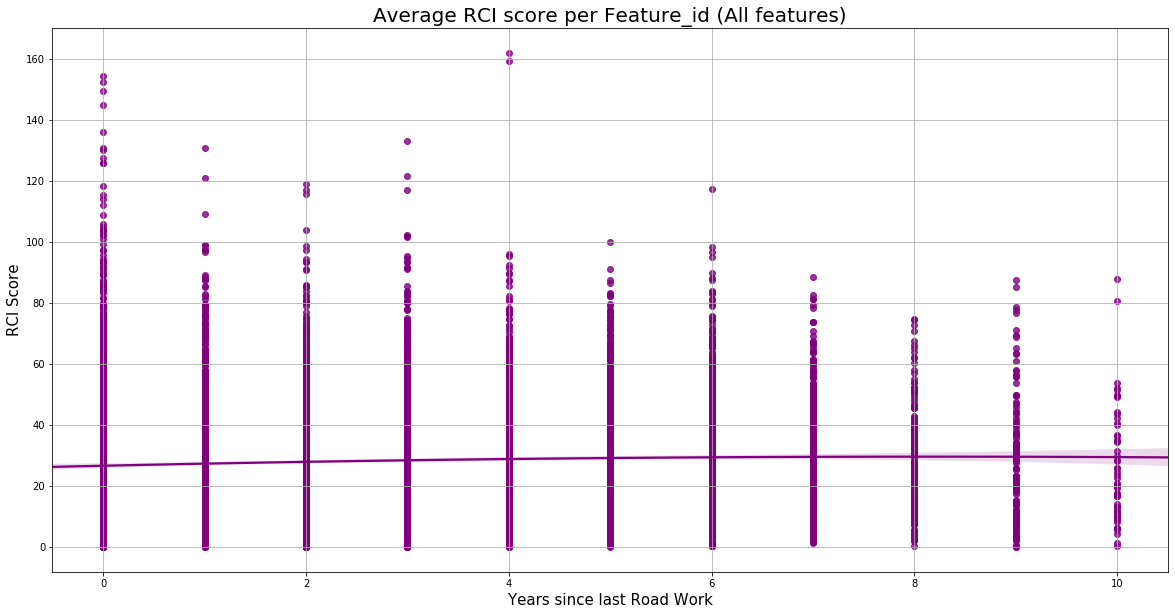

In [29]:
#Plot the RCI scores related to the year after a maintenance work was performed **ALL FEATURE IDs
temp = curve_set1.loc[~curve_set1['sub_obs_val_avg'].isnull()]
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['sub_obs_val_avg'] #Considering the avg value CHANGE FOR OTHER AGGREGATION METHODS
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='purple', order = 2)
plt.grid()
plt.title("Average RCI score per Feature_id (All features)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the set is: ' + str(len(X_fig)))

The shape of the set is: 8406


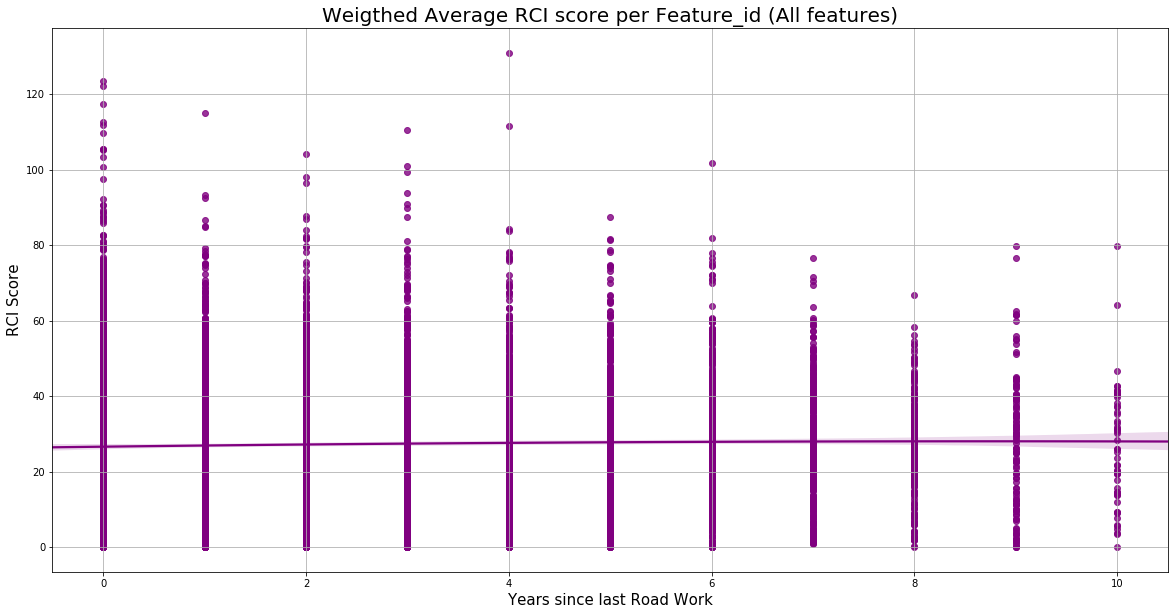

In [30]:
#ALL FEATURES - WEIGHTED AVERAGE
#Plot the RCI scores related to the year after a maintenance work was performed **ALL FEATURE IDs
temp = curve_set1.loc[~curve_set1['weighted_av'].isnull()]
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['weighted_av'] #Considering the avg value CHANGE FOR OTHER AGGREGATION METHODS
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='purple', order = 2)
plt.grid()
plt.title("Weigthed Average RCI score per Feature_id (All features)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the set is: ' + str(len(X_fig)))

The shape of the set is: 8406


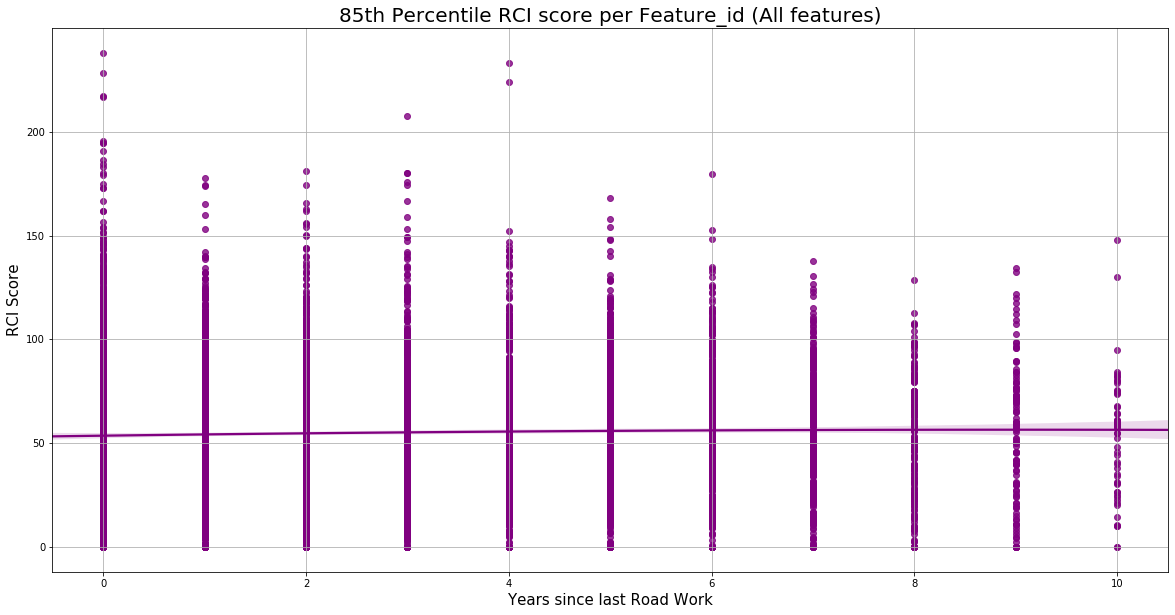

In [31]:
#ALL FEATURES - 85th PERCENTILE 
#Plot the RCI scores related to the year after a maintenance work was performed **ALL FEATURE IDs
temp = curve_set1.loc[~curve_set1['perc85'].isnull()]
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['perc85'] #Considering the avg value CHANGE FOR OTHER AGGREGATION METHODS
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='purple', order = 2)
plt.grid()
plt.title("85th Percentile RCI score per Feature_id (All features)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the set is: ' + str(len(X_fig)))

The shape of the Urban set is:2432


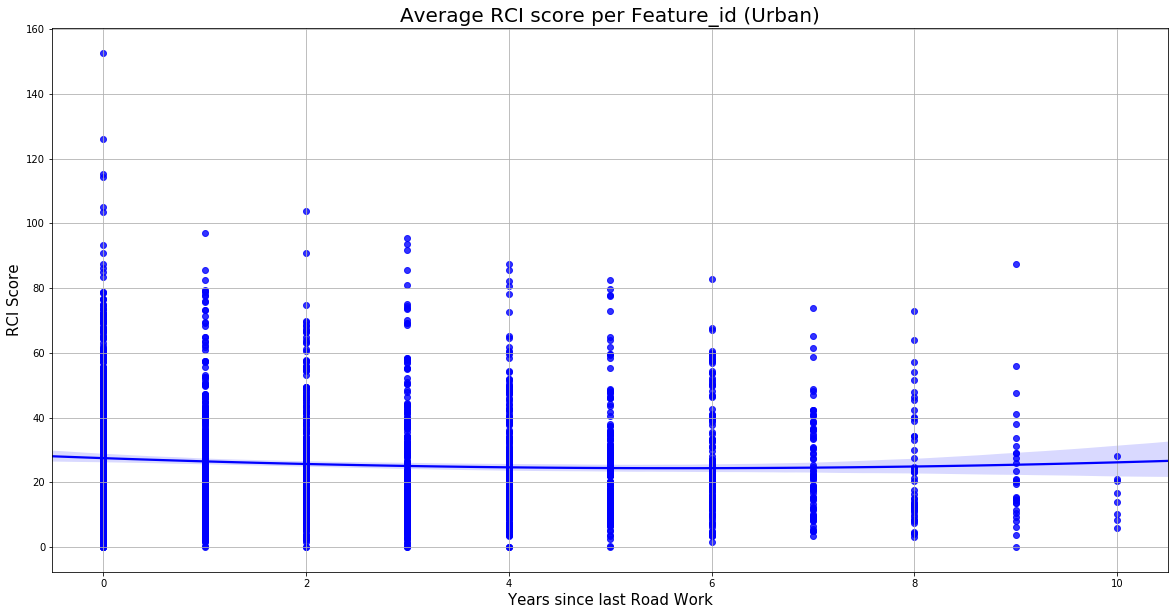

In [32]:
#URBAN - AVERAGE
#Plot the RCI scores related to the year after a maintenance work was performed **URBAN
temp = curve_set1.loc[curve_set1['urban_rural']=='Urban']
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['sub_obs_val_avg'] #Considering the average
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='blue', order = 2)
plt.grid()
plt.title("Average RCI score per Feature_id (Urban)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the Urban set is:' + str(len(X_fig)))

The shape of the Urban set is:2432


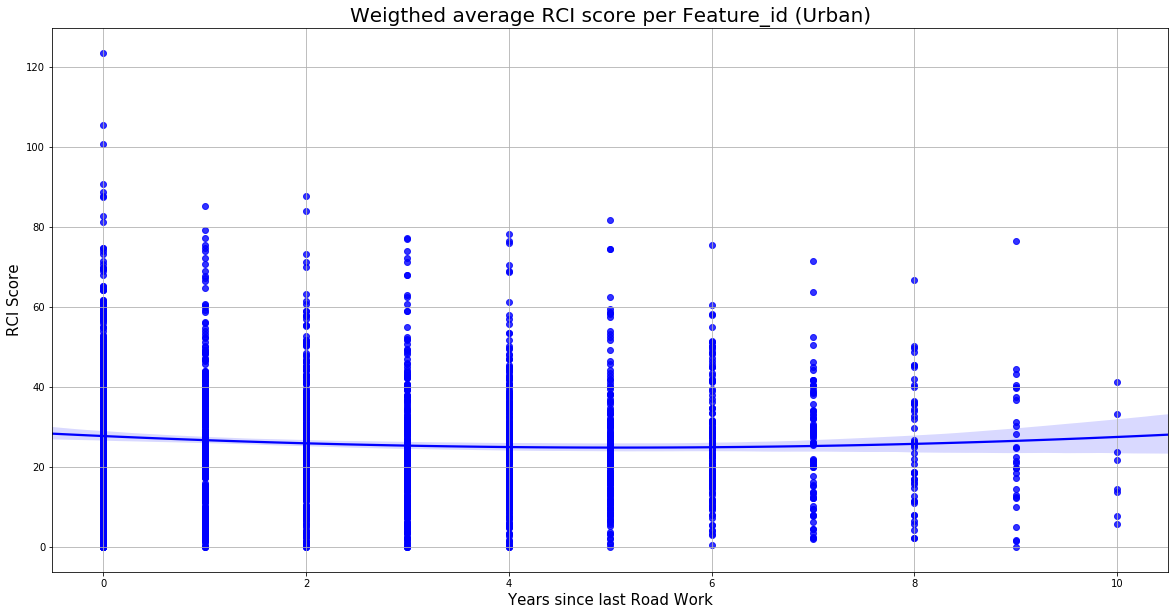

In [33]:
#URBAN - Weighted Average
#Plot the RCI scores related to the year after a maintenance work was performed **URBAN
temp = curve_set1.loc[curve_set1['urban_rural']=='Urban']
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['weighted_av'] #Considering the weigthed average
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='blue', order = 2)
plt.grid()
plt.title("Weigthed average RCI score per Feature_id (Urban)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the Urban set is:' + str(len(X_fig)))

The shape of the Urban set is:2432


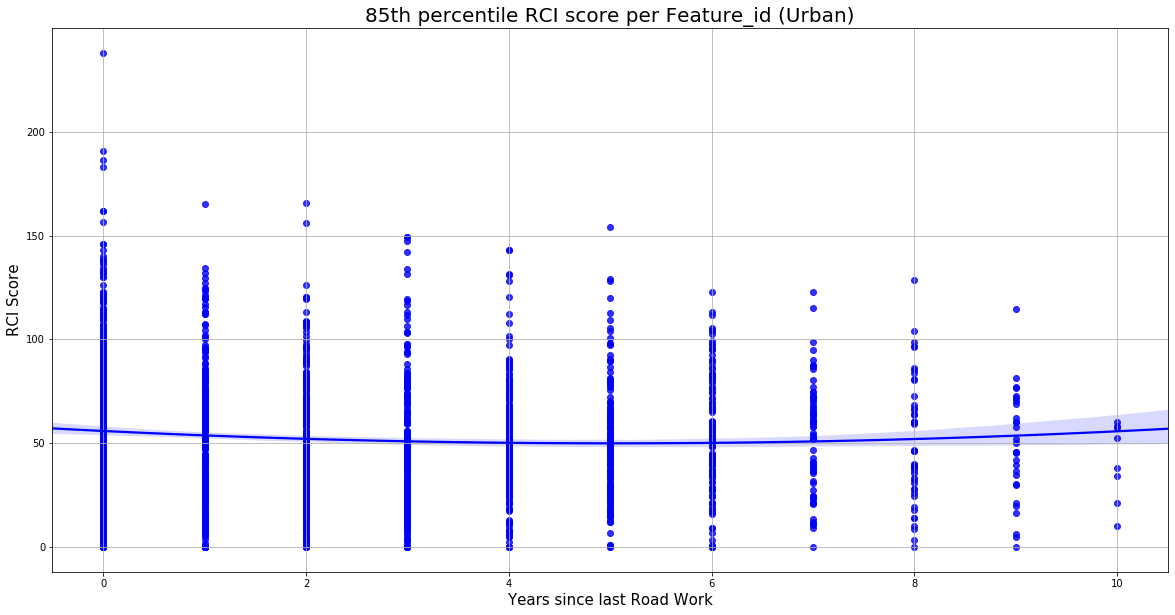

In [34]:
#URBAN - 85th PERCENTILE
#Plot the RCI scores related to the year after a maintenance work was performed **URBAN
temp = curve_set1.loc[curve_set1['urban_rural']=='Urban']
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['perc85'] #Considering the weigthed average
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='blue', order = 2)
plt.grid()
plt.title("85th percentile RCI score per Feature_id (Urban)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the Urban set is:' + str(len(X_fig)))

The shape of the Urban set is:5919


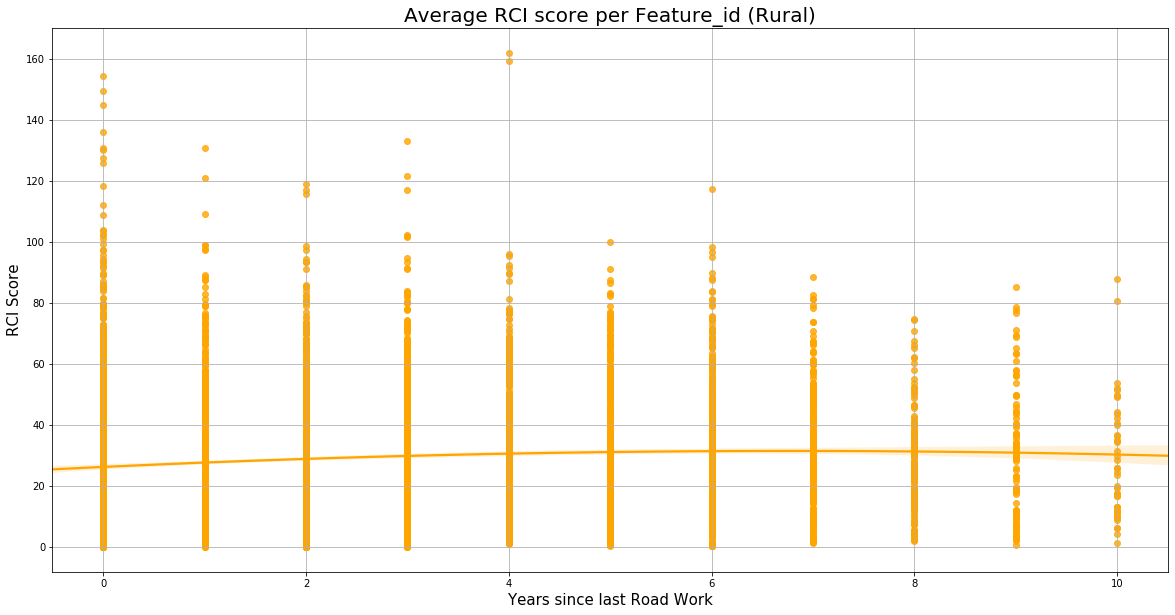

In [35]:
#RURAL - AVERAGE
#Plot the RCI scores related to the year after a maintenance work was performed **URBAN
temp = curve_set1.loc[curve_set1['urban_rural']=='Rural']
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['sub_obs_val_avg'] #Considering the average
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='orange', order = 2)
plt.grid()
plt.title("Average RCI score per Feature_id (Rural)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the Urban set is:' + str(len(X_fig)))


The shape of the Urban set is:5919


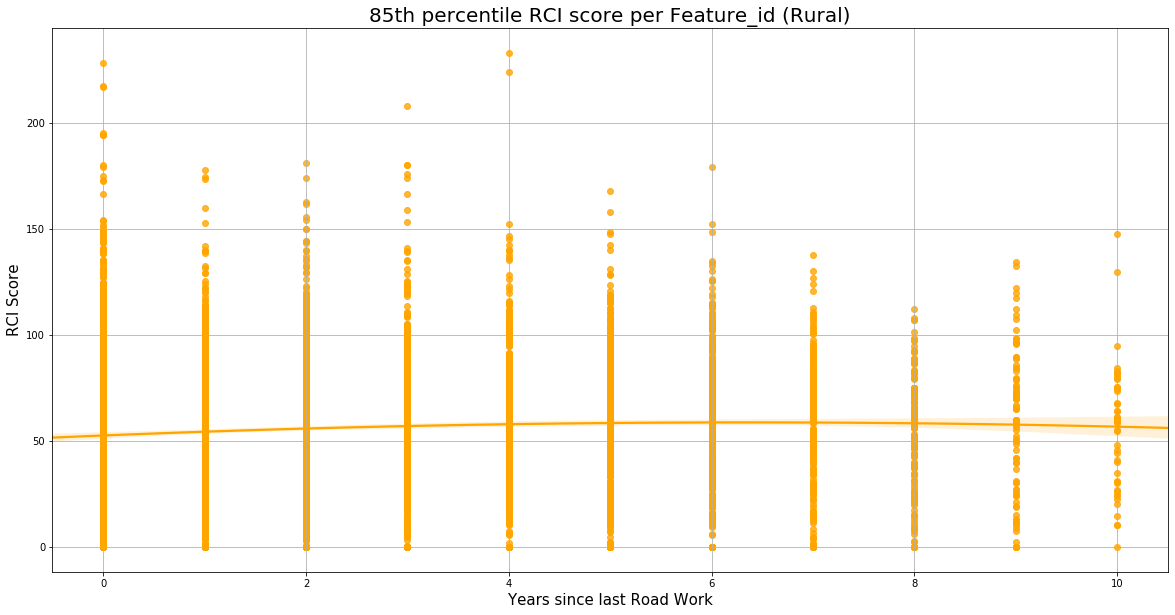

In [36]:
#RURAL - 85th PERCENTILE
#Plot the RCI scores related to the year after a maintenance work was performed **URBAN
temp = curve_set1.loc[curve_set1['urban_rural']=='Rural']
temp = temp.loc[temp['Years_since']!=12]
X_fig = temp['Years_since']
Y_fig = temp['perc85'] #Considering the weigthed average
plt.figure(figsize=(20,10))
#plt.scatter(X_fig, Y_fig, color='blue', linewidth=3)
sns.regplot(X_fig, Y_fig, color='orange', order = 2)
plt.grid()
plt.title("85th percentile RCI score per Feature_id (Rural)",
          fontsize=20)
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)
print('The shape of the Urban set is:' + str(len(X_fig)))

The shape of the MN Main Distributor set is:1778
The shape of the SD Secondary Distributor set is:2281
The shape of the L2 Local Access set is:1658
The shape of the L1 Local Distributor set is:1624
The shape of the PR Primary Distributor set is:1010
The shape of the 0 set is:55


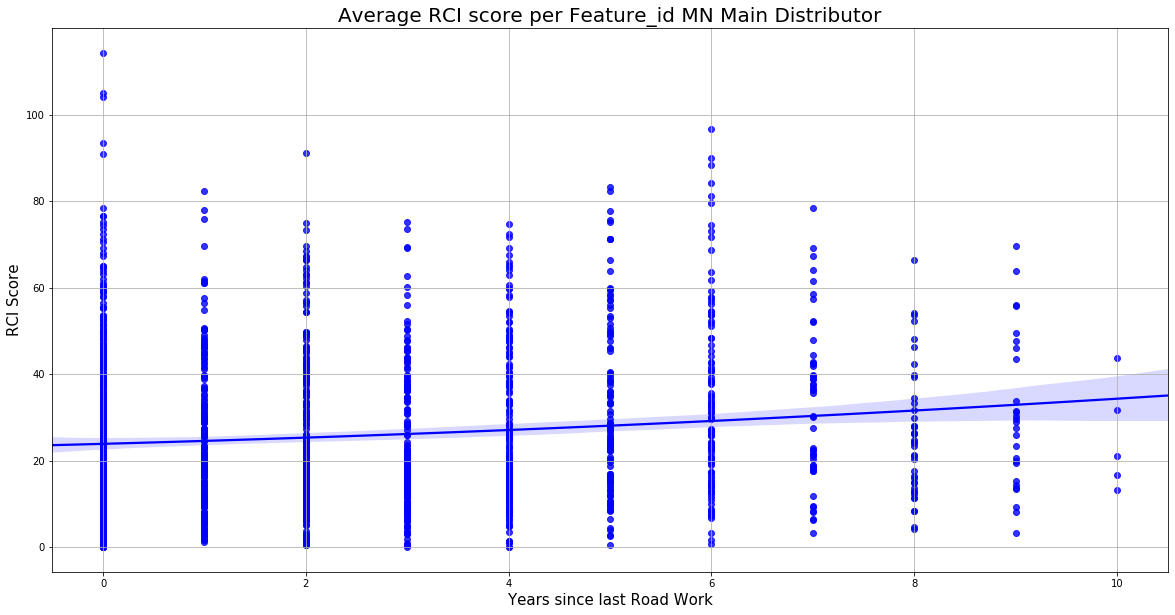

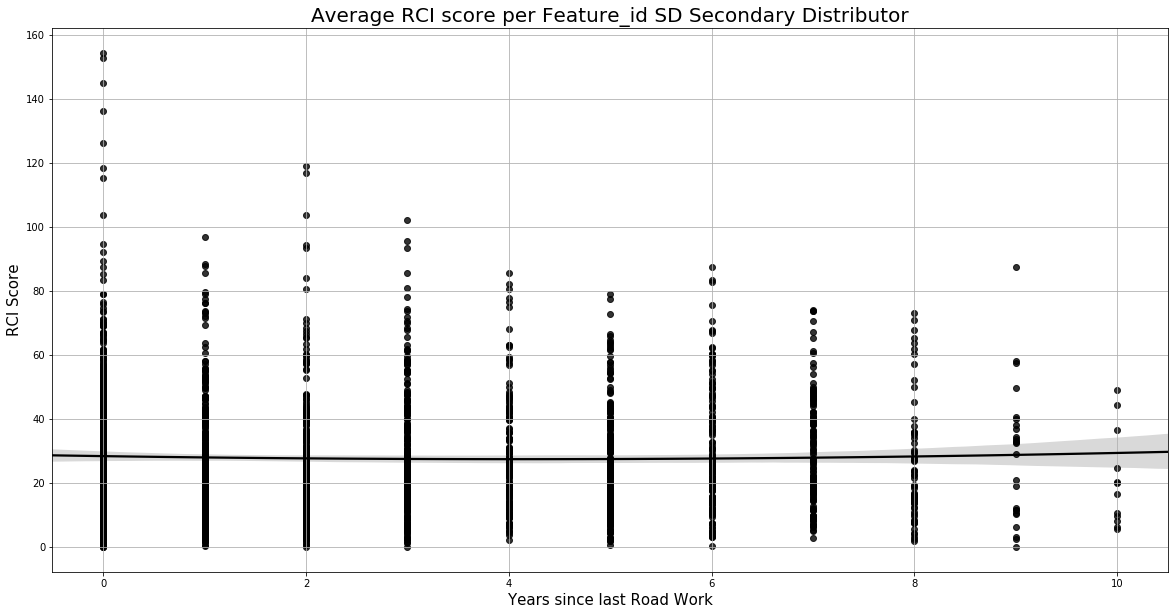

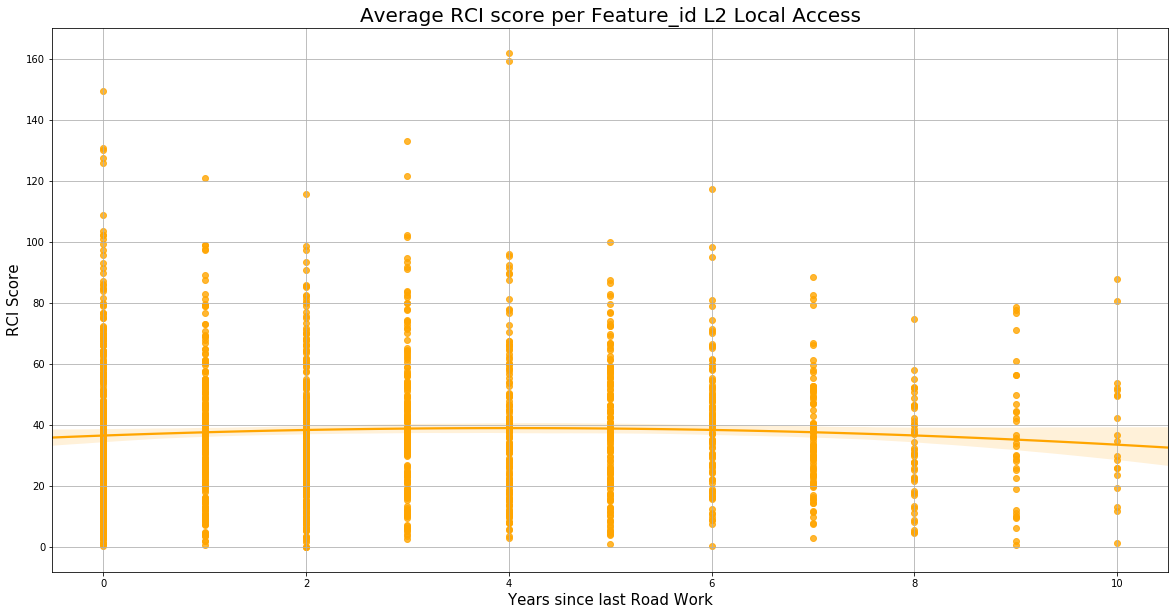

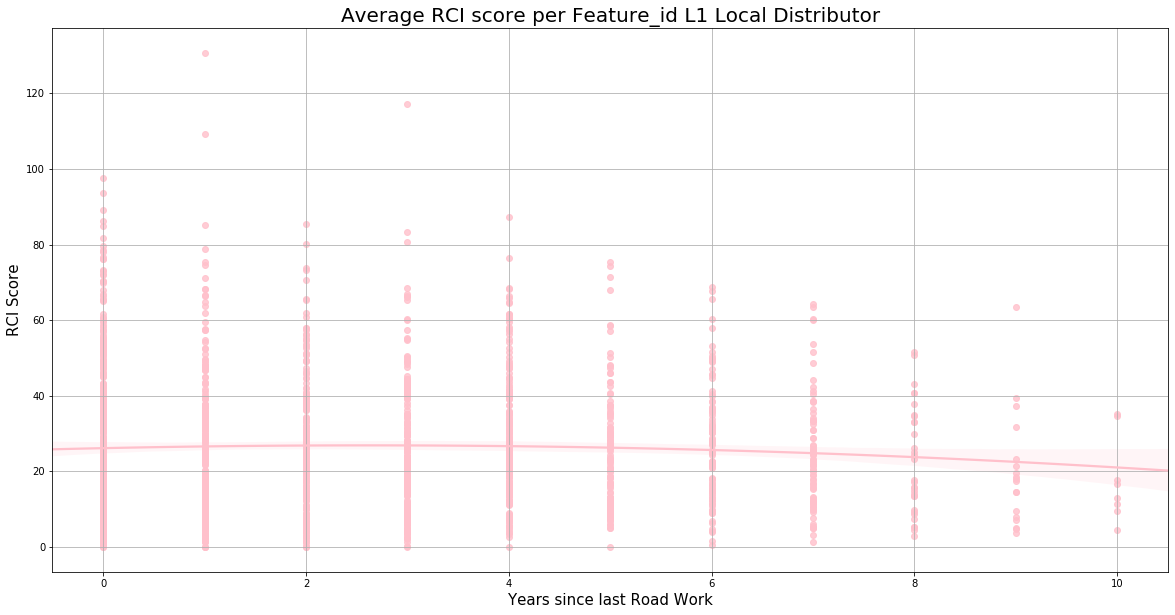

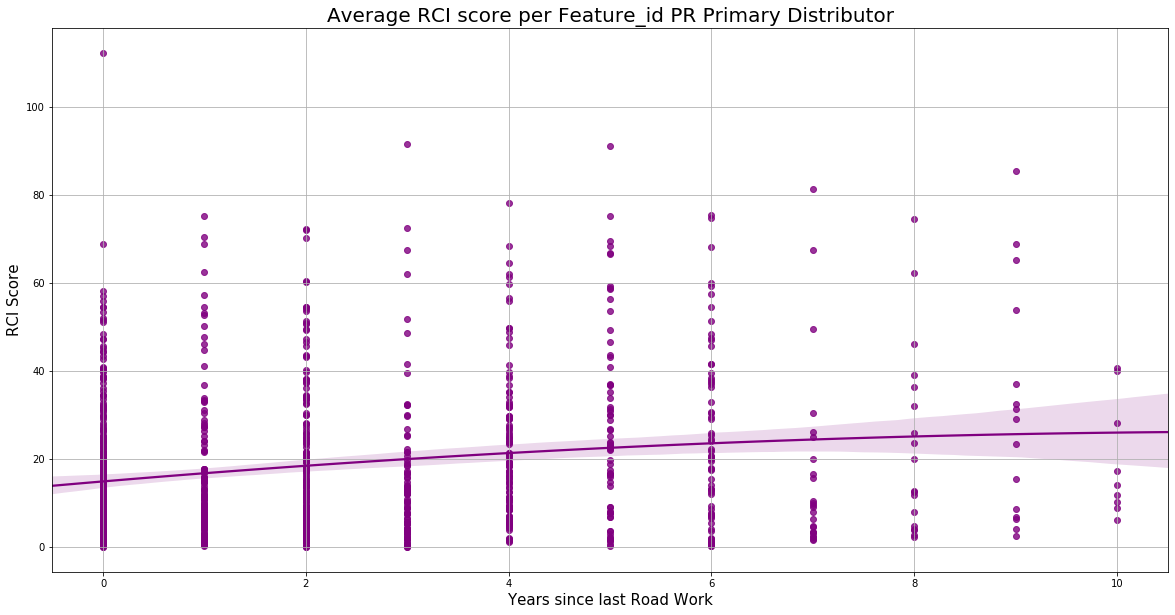

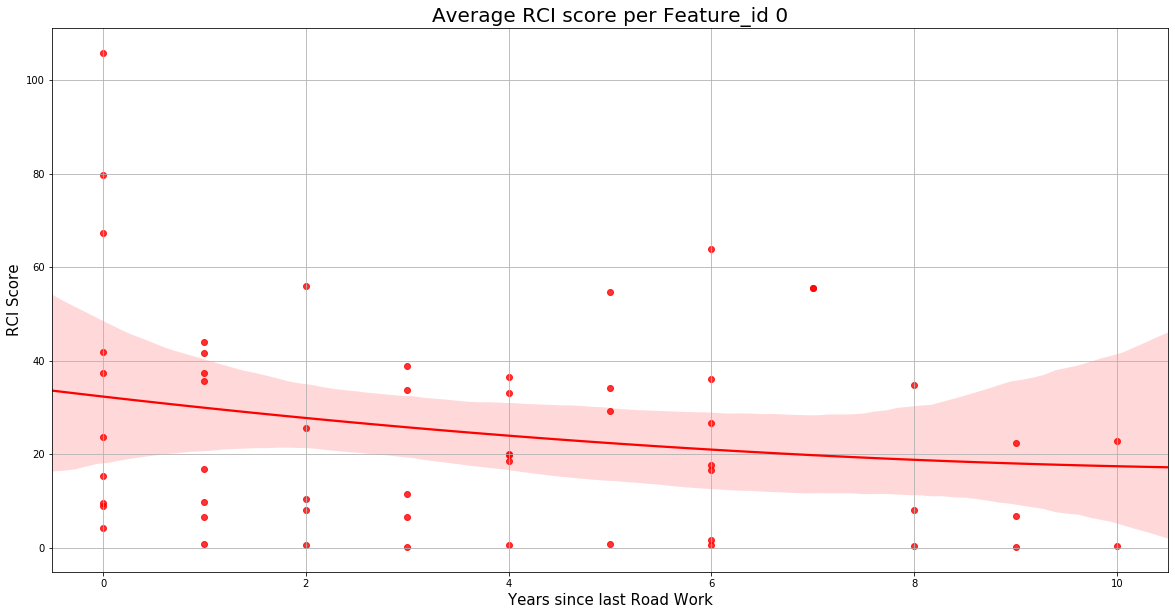

In [37]:
#HIERARCHY - AVERAGE
#Plot the RCI scores related to the year after a maintenance work was performed per Hierarchy
hierarchy = curve_set1['hierarchy'].value_counts().index.to_list()
colors = ['white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral',
         'white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral']
i = 1
for h in hierarchy:
    temp = curve_set1.loc[curve_set1['hierarchy']==h]
    temp = temp.loc[temp['Years_since']!=12]
    X_fig = temp['Years_since']
    Y_fig = temp['sub_obs_val_avg']
    
    plt.figure(num=i, figsize=(20,10))
    #plt.scatter(X_fig, Y_fig, color=colors[i], linewidth=3)
    sns.regplot(X_fig, Y_fig, color=colors[i], order =2)
    plt.grid()
    plt.title("Average RCI score per Feature_id " + str(h),
              fontsize=20)
    plt.xlabel('Years since last Road Work', fontsize=15)
    plt.ylabel('RCI Score', fontsize=15)
    print('The shape of the ' +  str(h)+ ' set is:' + str(len(X_fig)))
    i +=1

The shape of the MN Main Distributor set is:1778
The shape of the SD Secondary Distributor set is:2281
The shape of the L2 Local Access set is:1658
The shape of the L1 Local Distributor set is:1624
The shape of the PR Primary Distributor set is:1010
The shape of the 0 set is:55


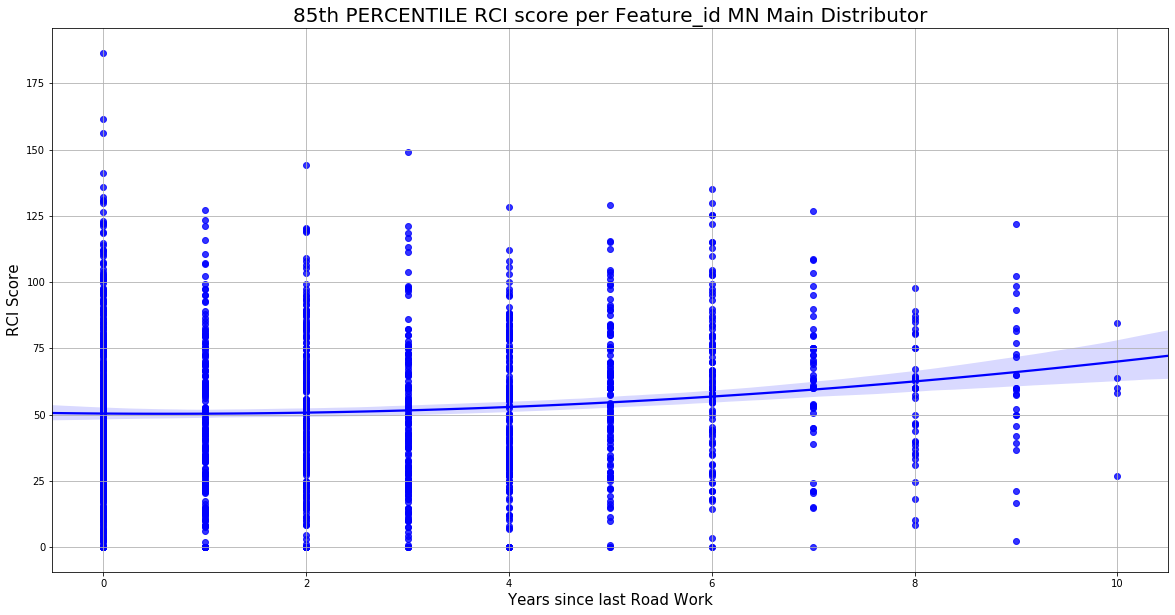

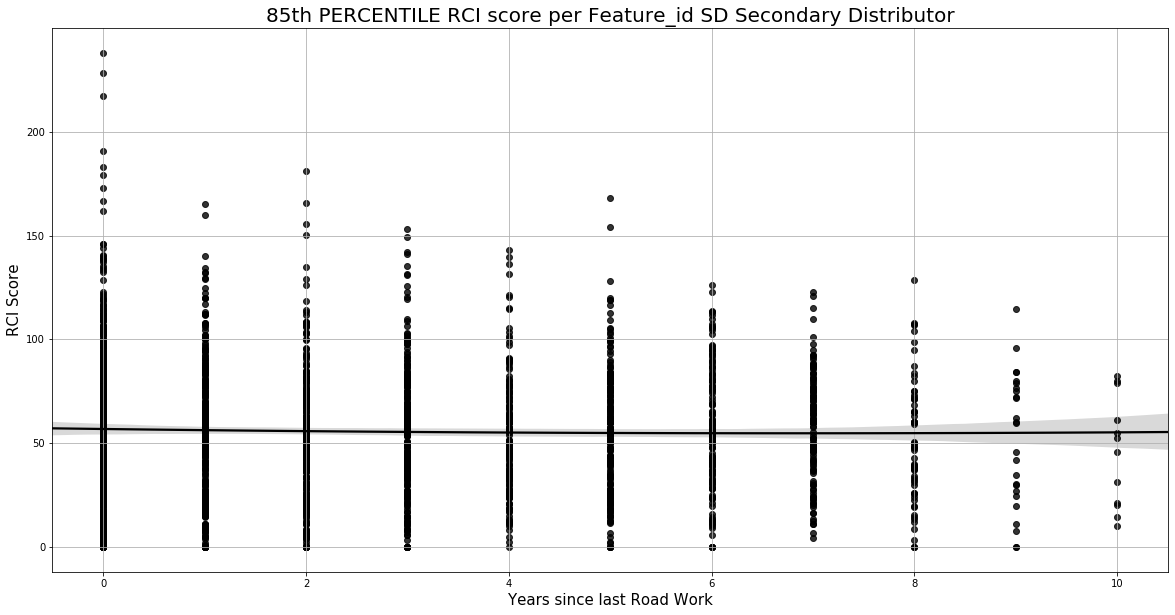

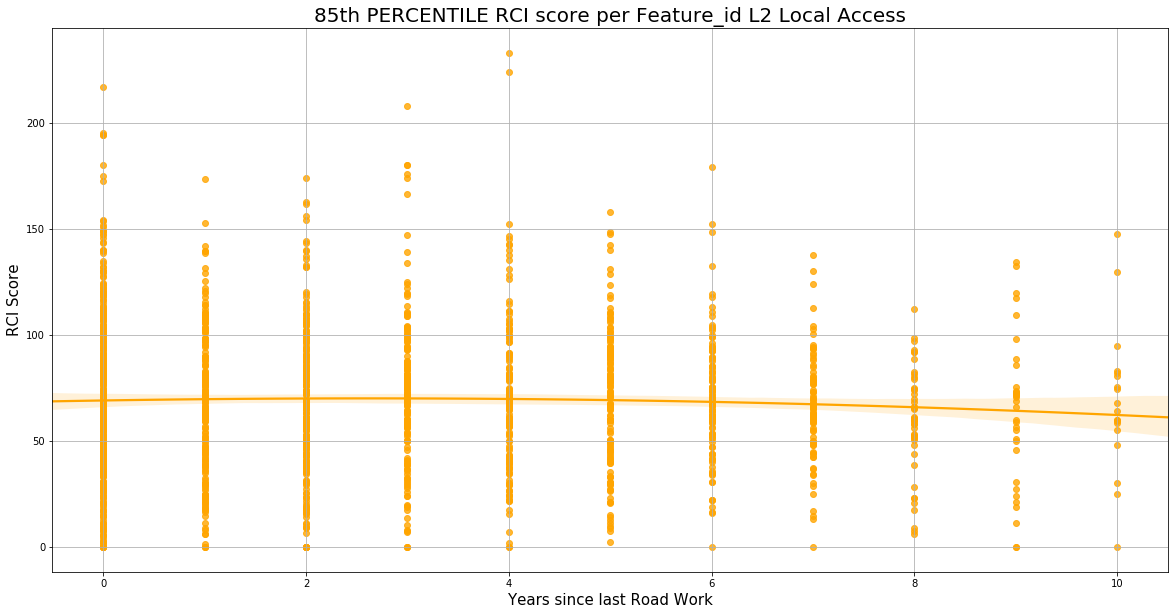

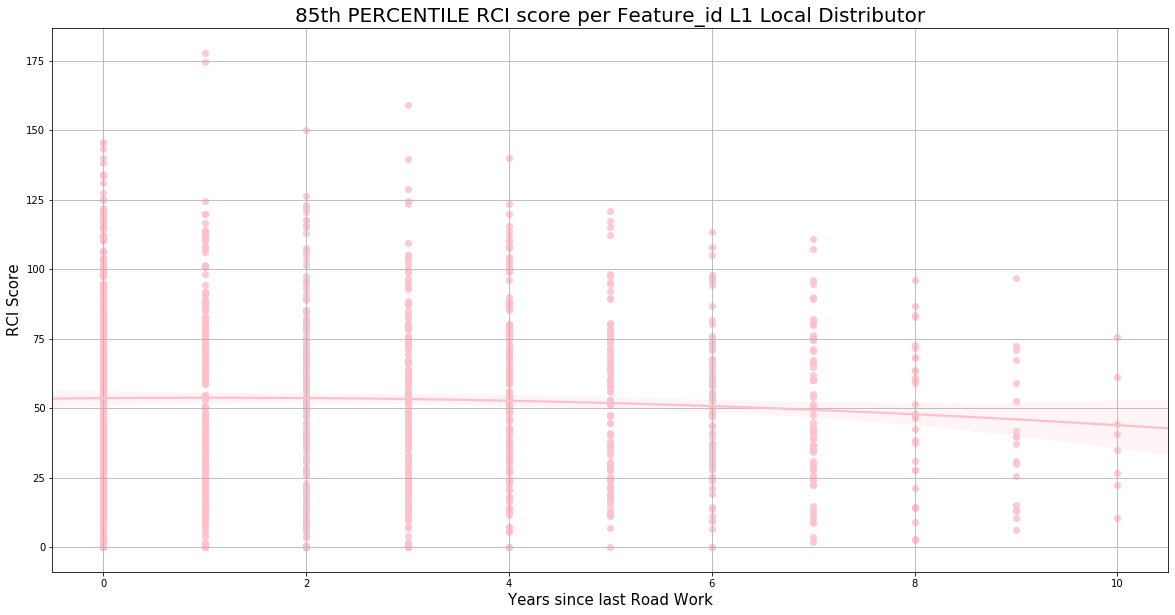

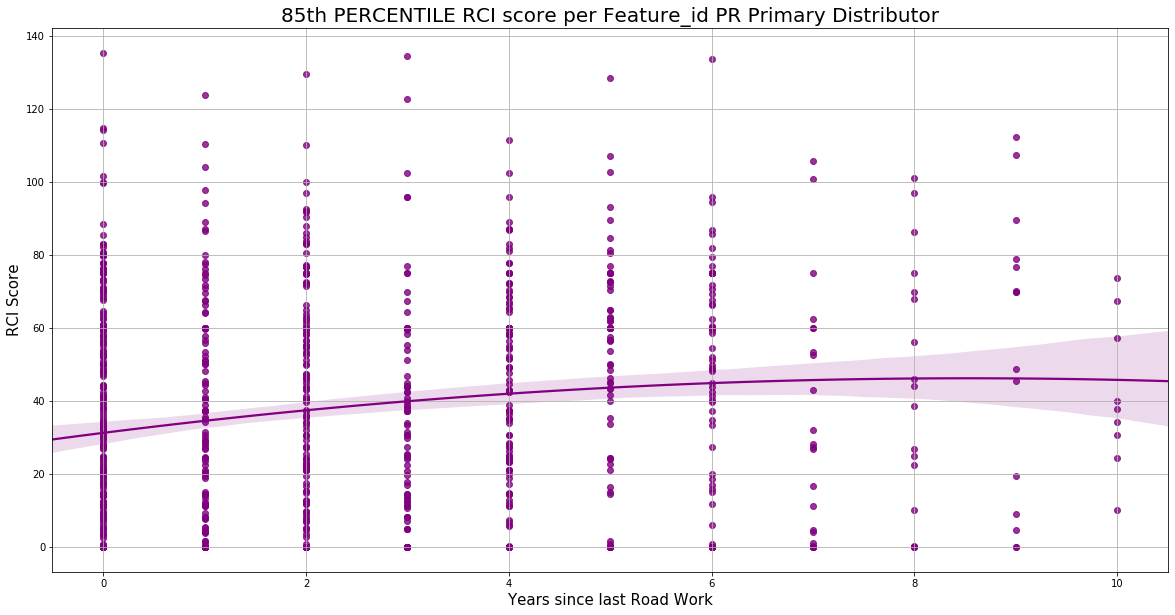

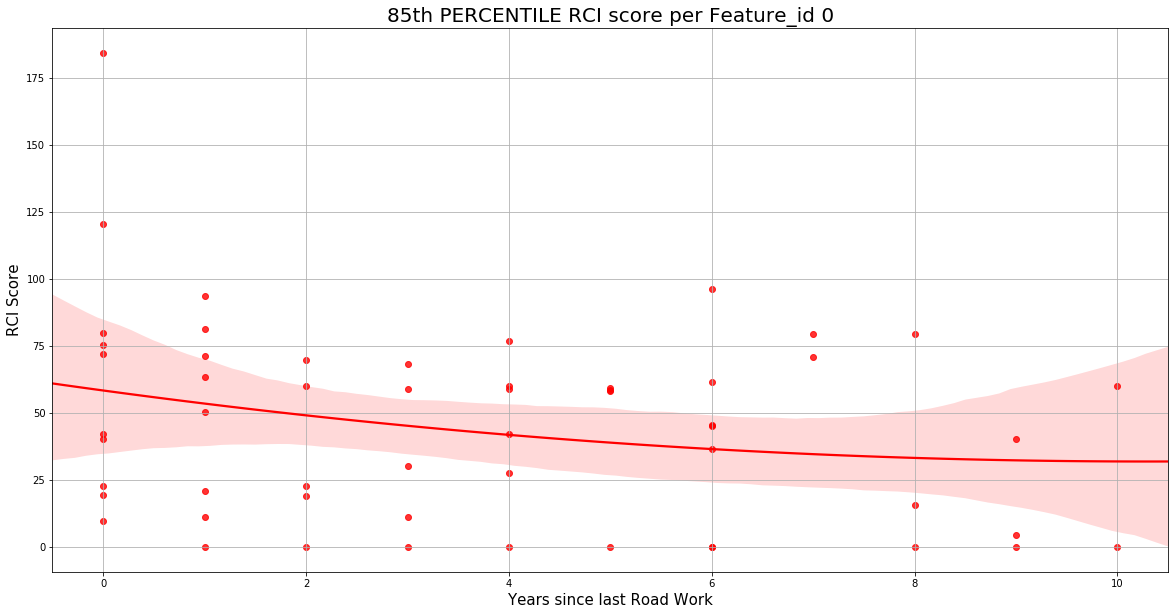

In [38]:
#HIERARCHY - 85TH PERCENTILE
#Plot the RCI scores related to the year after a maintenance work was performed per Hierarchy
hierarchy = curve_set1['hierarchy'].value_counts().index.to_list()
colors = ['white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral',
         'white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral']
i = 1
for h in hierarchy:
    temp = curve_set1.loc[curve_set1['hierarchy']==h]
    temp = temp.loc[temp['Years_since']!=12]
    X_fig = temp['Years_since']
    Y_fig = temp['perc85']
    
    plt.figure(num=i, figsize=(20,10))
    #plt.scatter(X_fig, Y_fig, color=colors[i], linewidth=3)
    sns.regplot(X_fig, Y_fig, color=colors[i], order =2)
    plt.grid()
    plt.title("85th PERCENTILE RCI score per Feature_id " + str(h),
              fontsize=20)
    plt.xlabel('Years since last Road Work', fontsize=15)
    plt.ylabel('RCI Score', fontsize=15)
    print('The shape of the ' +  str(h)+ ' set is:' + str(len(X_fig)))
    i +=1

The shape of the Single 2-Lane Carriageway set is:6517
The shape of the Dual 2 Lane set is:1371
The shape of the Carriageway Oneway 2-Lane set is:163
The shape of the Carriageway Oneway 1-Lane set is:65
The shape of the Slip/Feeder Road Oneway 2-Lane set is:43
The shape of the Slip/Feeder Road Oneway 1-Lane set is:39
The shape of the 0 set is:55
The shape of the Single Lane Carriageway set is:68
The shape of the Dual 3 Lane set is:35
The shape of the Carriageway Oneway 3-Lane set is:23


TypeError: expected non-empty vector for x

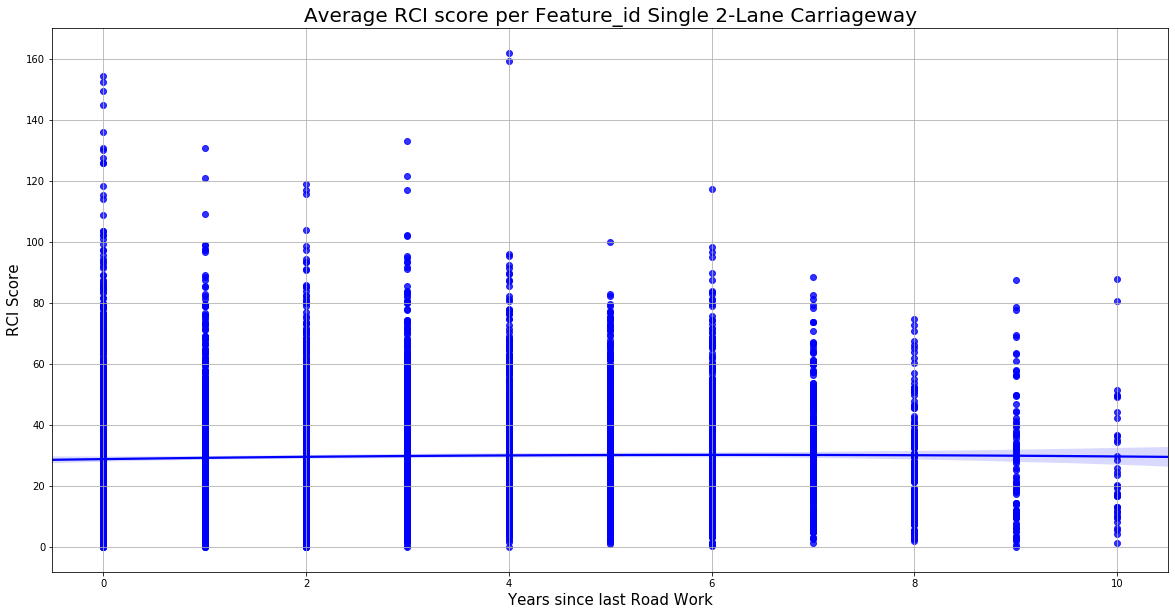

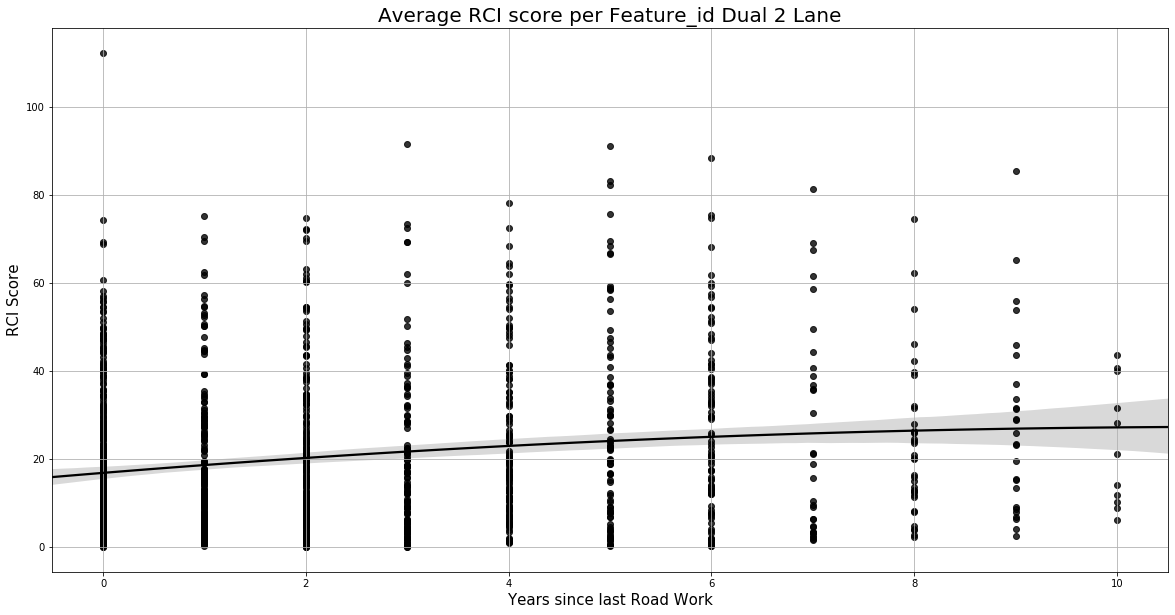

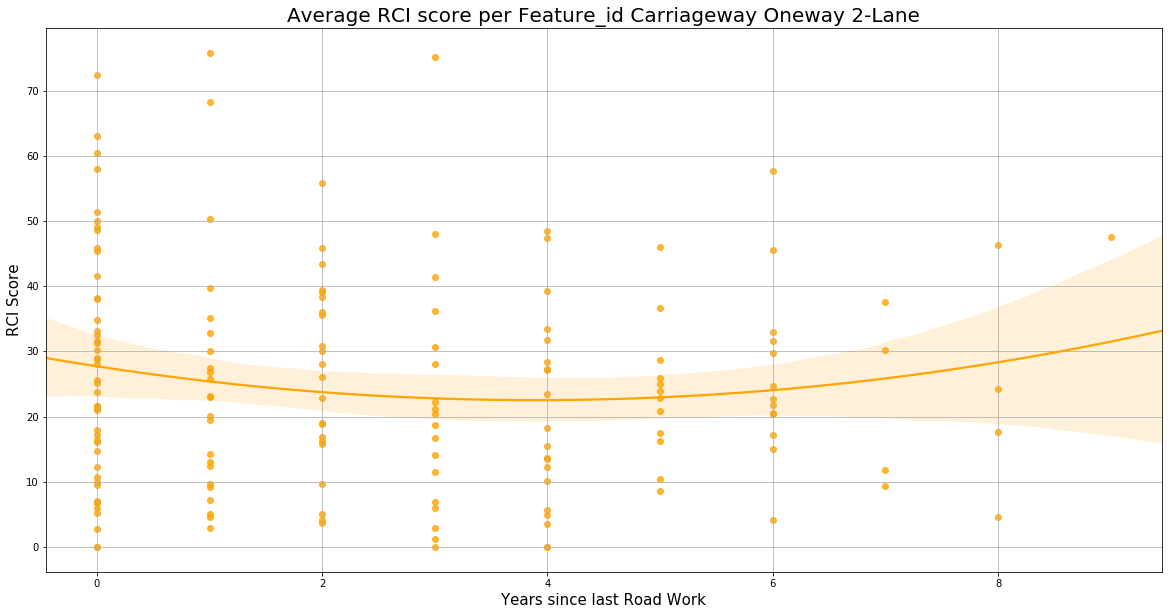

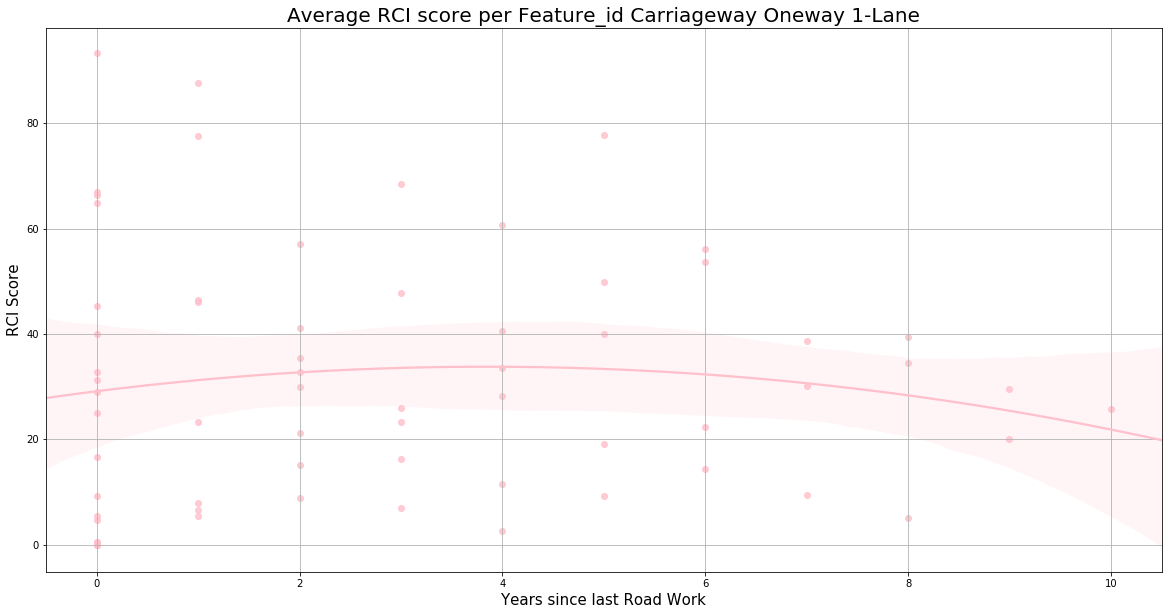

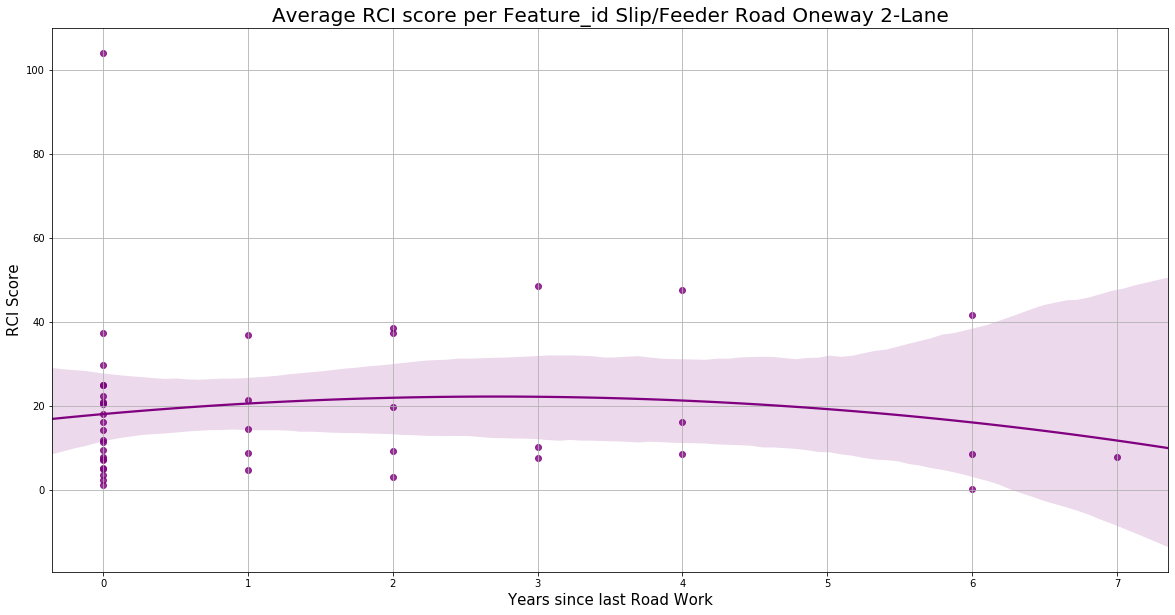

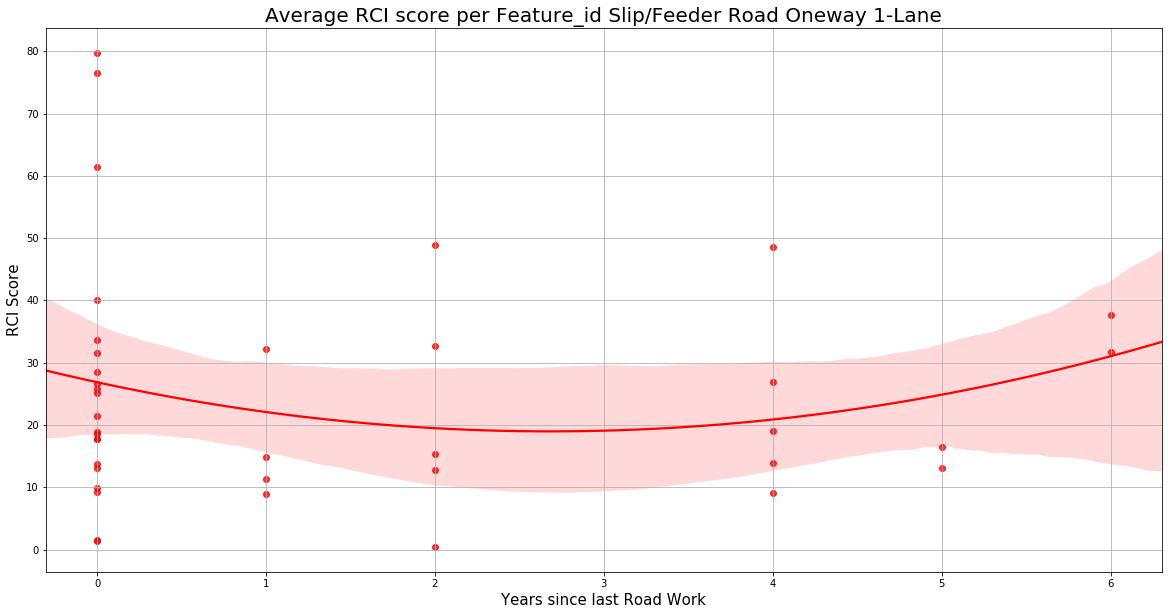

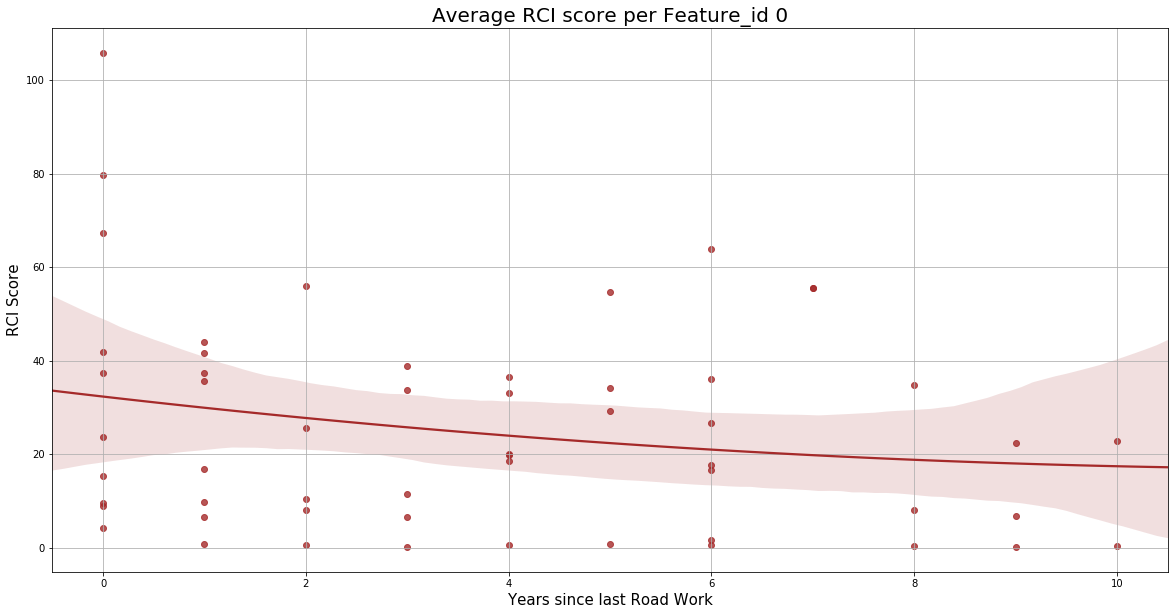

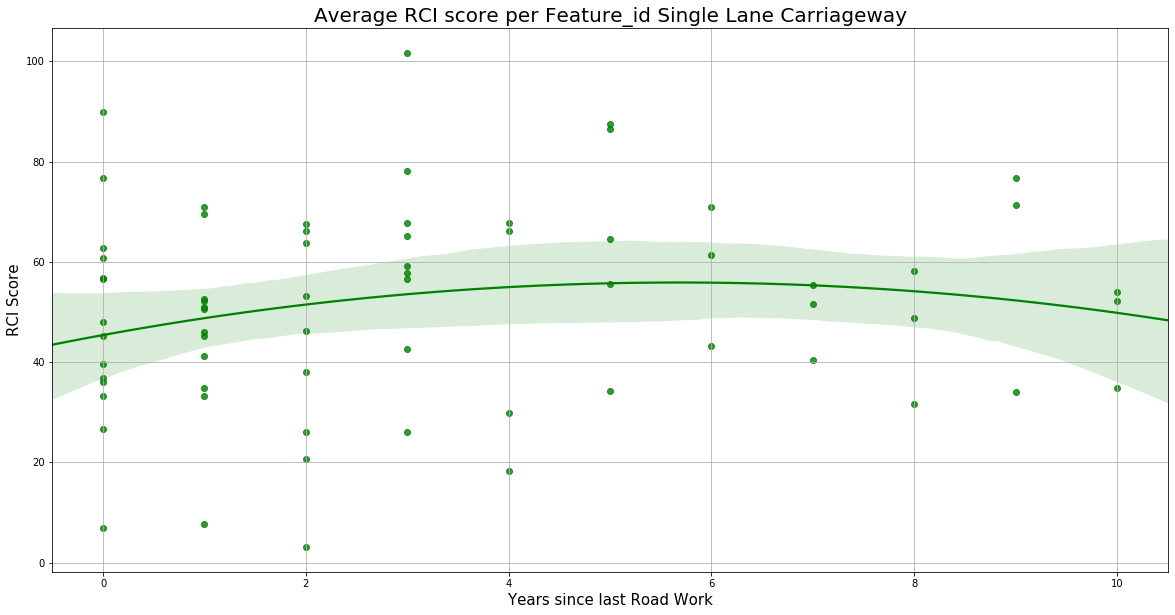

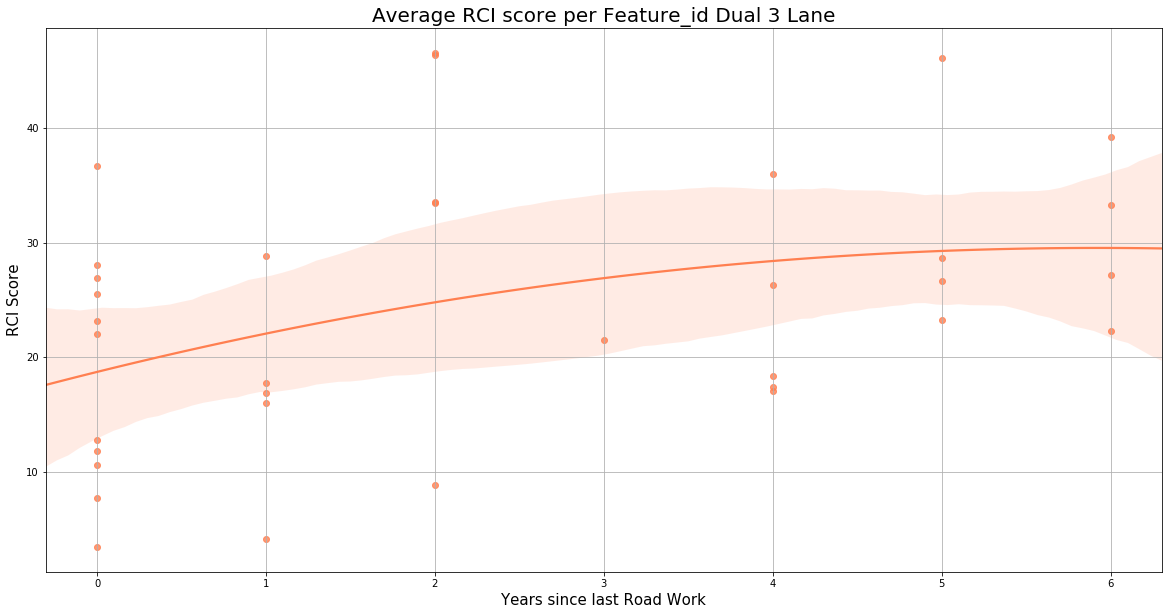

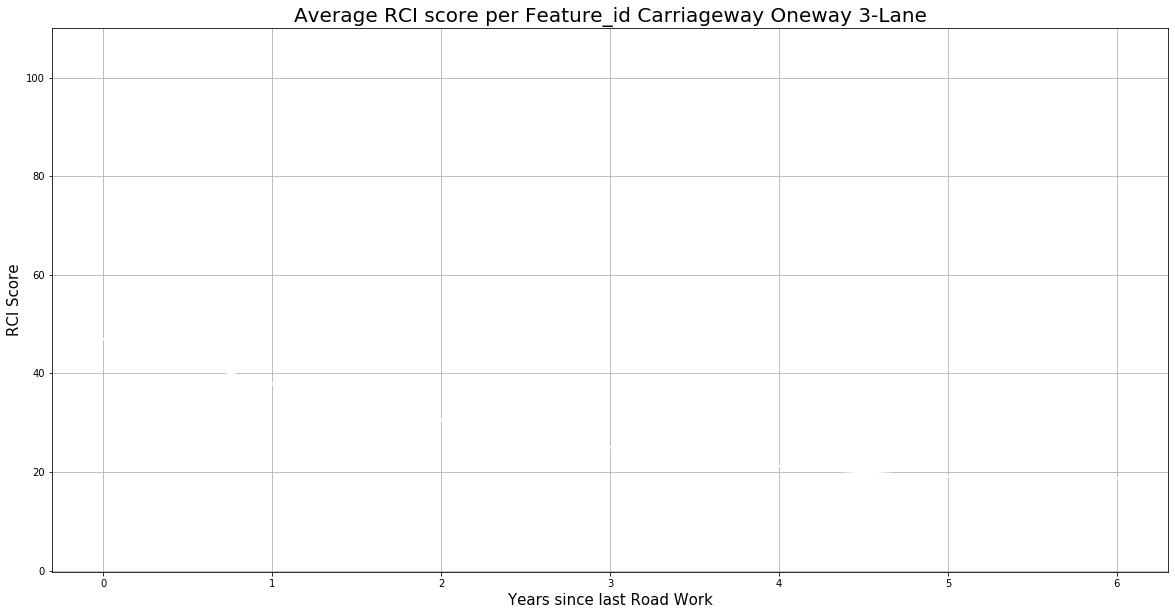

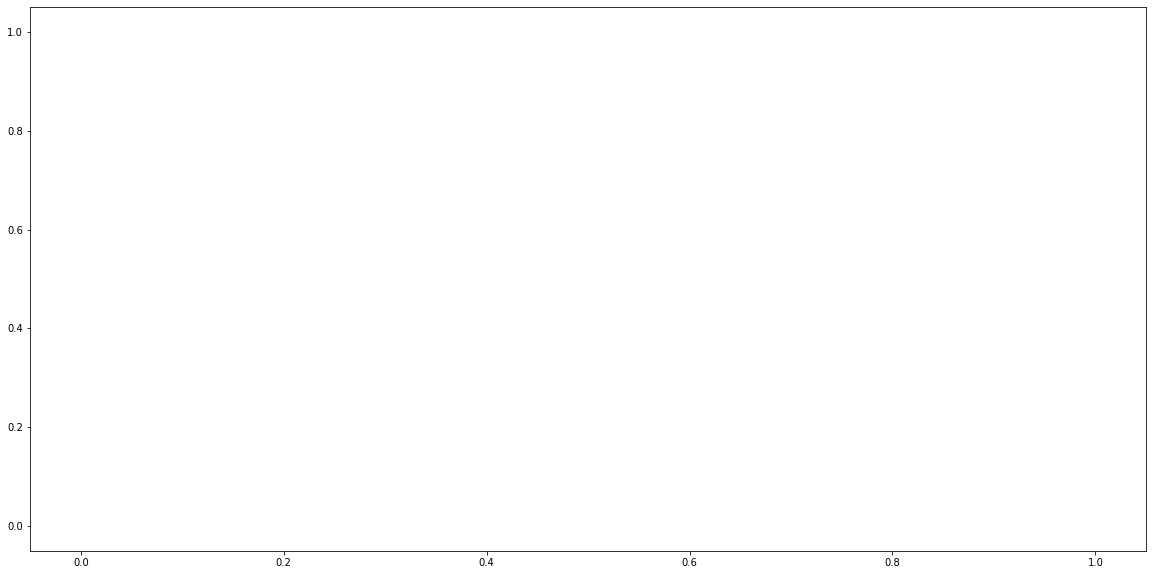

In [39]:
#Plot the RCI scores related to the year after a maintenance work was performed per Road Type
r_type = curve_set1['road_type_hw'].value_counts().index.to_list()
colors = ['white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral',
         'white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral']
i = 1
for h in r_type:
    temp = curve_set1.loc[curve_set1['road_type_hw']==h]
    temp = temp.loc[temp['Years_since']!=12]
    X_fig = temp['Years_since']
    Y_fig = temp['sub_obs_val_avg']
    
    plt.figure(num=i, figsize=(20,10))
    #plt.scatter(X_fig, Y_fig, color=colors[i], linewidth=3)
    sns.regplot(X_fig, Y_fig, color=colors[i], order =2)
    plt.grid()
    plt.title("Average RCI score per Feature_id " + str(h),
              fontsize=20)
    plt.xlabel('Years since last Road Work', fontsize=15)
    plt.ylabel('RCI Score', fontsize=15)
    print('The shape of the ' +  str(h)+ ' set is:' + str(len(X_fig)))
    i +=1

In [ ]:
#HIERARCHY - 85TH PERCENTILE
#Plot the RCI scores related to the year after a maintenance work was performed per Road Type
r_type = curve_set1['road_type_hw'].value_counts().index.to_list()
colors = ['white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral',
         'white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral']
i = 1
for h in r_type:
    temp = curve_set1.loc[curve_set1['road_type_hw']==h]
    temp = temp.loc[temp['Years_since']!=12]
    X_fig = temp['Years_since']
    Y_fig = temp['sub_obs_val_avg']
    
    plt.figure(num=i, figsize=(20,10))
    #plt.scatter(X_fig, Y_fig, color=colors[i], linewidth=3)
    sns.regplot(X_fig, Y_fig, color=colors[i], order =2)
    plt.grid()
    plt.title("Average RCI score per Feature_id " + str(h),
              fontsize=20)
    plt.xlabel('Years since last Road Work', fontsize=15)
    plt.ylabel('RCI Score', fontsize=15)
    print('The shape of the ' +  str(h)+ ' set is:' + str(len(X_fig)))
    i +=1

In [76]:
curve_set1.loc[curve_set1['Years_since']==0]

,feature_id,FinancialY,sub_obs_val_med,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,Prev_RCI,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width
2,B486/20,2011,33.33,50.00,14.081330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.700,GYCK,GYCK,3.0,SD Secondary Distributor,98,Single 2-Lane Carriageway,Urban,BITM,8.34
19,C29/80,2016,0.00,35.11,7.385110,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,130.270,GSG,WHCK,9.0,L2 Local Access,288,Single 2-Lane Carriageway,Rural,BITM,8.88
32,C10/608,2017,0.00,60.00,11.907835,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,142.220,TILL,WHCK,4.0,L2 Local Access,308,Single 2-Lane Carriageway,Rural,BITM,4.21
43,C29/90,2016,0.00,73.00,16.265915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,133.600,GSG,WHCK,9.0,L2 Local Access,215,Single 2-Lane Carriageway,Rural,BITM,11.19
77,C29/95,2014,60.00,103.78,29.507894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,140.000,GSG,WHCK,6.0,L2 Local Access,90,Single 2-Lane Carriageway,Rural,BITM,11.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31006,C57/15,2019,0.00,0.00,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,LMBE,LMBE,8.0,L1 Local Distributor,30,Single 2-Lane Carriageway,Rural,unknown,7.422663755458514
31026,A41/314,2015,0.00,74.00,7.580896,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,127.000,ALV,WHCK,7.0,PR Primary Distributor,2460,Dual 2 Lane,Rural,BITM,9.22
31049,C64/110,2014,65.20,163.00,62.637754,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,136.905,CWF,LMBE,7.0,L2 Local Access,118,Single 2-Lane Carriageway,Rural,BITM,8.56
31342,C65/10,2019,0.00,100.00,12.212529,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,120.000,CWF,WHCK,5.0,L1 Local Distributor,1973,Single 2-Lane Carriageway,Rural,unknown,7.422663755458514


In [352]:
curve_set1.loc[curve_set1['Years_since']==10]

,feature_id,FinancialY,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,Prev_RCI,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,sub_obs_val_avg,weighted_av,perc85
547,C51/50,2019,130.00,26.641366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,144.08,GSG,WHCK,0.0,L2 Local Access,1769.0,Single 2-Lane Carriageway,Rural,BITM,6.02,25.816127,25.985688,58.4480
577,C15/130,2019,104.09,28.070653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,201.67,TILL,WHCK,0.0,L2 Local Access,414.0,Single 2-Lane Carriageway,Rural,BITM,4.55,42.367619,38.062160,75.2900
757,B1038/70,2019,124.00,28.982383,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,148.00,TILL,WHCK,0.0,SD Secondary Distributor,1229.0,Single 2-Lane Carriageway,Rural,BITM,5.61,20.080976,19.621119,45.9250
857,C15/120,2019,169.99,31.567719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,179.57,TILL,WHCK,0.0,L2 Local Access,1398.0,Single 2-Lane Carriageway,Rural,BITM,4.92,49.430290,37.336667,83.1175
957,C15/115,2019,79.15,26.754177,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,182.00,TILL,WHCK,0.0,L2 Local Access,326.0,Single 2-Lane Carriageway,Rural,BITM,4.99,29.713438,31.300718,64.3360
977,C15/15,2019,82.00,17.413596,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57.48,TILL,THAM,0.0,L1 Local Distributor,650.0,Single 2-Lane Carriageway,Rural,BITM,5.98,11.346094,9.315948,26.5500
1377,C5/20,2019,101.67,24.075885,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,113.45,TILL,WHCK,0.0,L1 Local Distributor,1811.0,Single 2-Lane Carriageway,Rural,BITM,4.97,17.738268,20.203564,40.8290
1537,B1038/65,2019,129.31,38.151874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,163.00,TILL,WHCK,0.0,SD Secondary Distributor,767.0,Single 2-Lane Carriageway,Rural,BITM,5.90,36.433611,41.446547,79.2065
1567,C10/10,2019,133.51,30.460076,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,168.14,GSG,WHCK,0.0,L1 Local Distributor,902.0,Single 2-Lane Carriageway,Rural,BITM,6.08,34.594943,30.332713,61.2000
1767,C5/40,2019,61.92,10.979442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,68.83,WHCK,WHCK,0.0,L1 Local Distributor,2786.0,Single 2-Lane Carriageway,Rural,BITM,5.23,4.428345,3.761663,10.4320


In [62]:
feat = 'C83/10'
feat_set = curve_set1.loc[curve_set1['feature_id']==feat]
feat_set.reset_index(drop= True, inplace = True)
length = feat_set.iloc[0,-8]
rtype = feat_set.iloc[0,-9]
urban = feat_set.iloc[0,-6]
print('The length of this feature ID is ' + str(length) + ' mts')
print('This road is a ' + str(rtype) + ' and of type ' + str(urban))

The length of this feature ID is 2289.0 mts
This road is a L2 Local Access and of type Rural


C:\Users\J FernandezGomez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\J FernandezGomez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<BarContainer object of 8 artists>

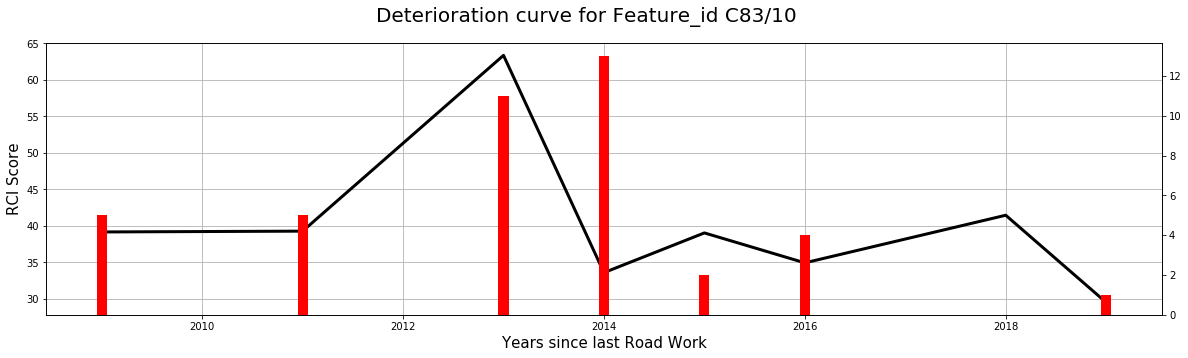

In [63]:
#Define the deterioration curve per individual Feature_Id based on Score, Maintenance Works and Defects
X_fig = feat_set['FinancialY']
Y_fig = feat_set['sub_obs_val_avg']

feat_set['Works']= feat_set.iloc[:,7:19].sum(axis=1)
Y2_fig = feat_set['Works']

feat_set['Defects']= feat_set.iloc[:,21:46].sum(axis=1)
Y3_fig = feat_set['Defects']

fig, ax1 = plt.subplots(figsize=(20, 5))
fig.suptitle("Deterioration curve for Feature_id " + str(feat),
          fontsize=20)

ax1.plot(X_fig, Y_fig, color= 'black', linewidth=3)
ax1.grid()
plt.xlabel('Years since last Road Work', fontsize=15)
plt.ylabel('RCI Score', fontsize=15)

ax2 = ax1.twinx()

ax2.bar(X_fig, Y3_fig, color= 'red', width= 0.1, label='Defects')
ax2.bar(X_fig, Y2_fig, color= 'blue', width= 0.1, label='Works')

In [55]:
Y2_fig

0    0.0
1    0.0
2    1.0
3    0.0
4    0.0
5    0.0
6    0.0
7    0.0
8    0.0
Name: Works, dtype: float64

In [59]:
feat_set

,feature_id,FinancialY,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,Prev_RCI,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,sub_obs_val_avg,weighted_av,perc85,Works,Defects
0,C83/10,2009,212.56,42.039185,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,212.560,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,39.159956,34.506160,77.4870,0.0,5.0
1,C83/10,2011,236.76,53.399167,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,224.660,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,39.271798,48.937277,100.0000,0.0,5.0
2,C83/10,2013,202.00,42.712365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0,0.0,219.380,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,63.370000,47.786334,100.8575,0.0,11.0
3,C83/10,2014,169.00,37.227643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,1.0,202.000,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,33.583524,31.873499,72.8760,0.0,13.0
4,C83/10,2015,160.90,32.812201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,169.000,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,39.028991,35.227357,79.8800,0.0,2.0
5,C83/10,2016,167.57,32.815268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.900,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,34.926541,31.780539,71.0800,0.0,4.0
6,C83/10,2018,178.44,36.067212,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,173.005,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,41.451894,37.604784,76.3470,0.0,0.0
7,C83/10,2019,148.23,29.231594,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,178.440,THAM,THAM,0.0,L2 Local Access,2289.0,Single 2-Lane Carriageway,Rural,RASH,7.73,29.496520,27.634441,57.2460,0.0,1.0


In [335]:
Y3_fig

0     5.0
1     4.0
2     0.0
3     1.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     1.0
10    2.0
Name: Defects, dtype: float64

In [336]:
Y2_fig

0     0.0
1     0.0
2     1.0
3     0.0
4     0.0
5     0.0
6     0.0
7     0.0
8     0.0
9     0.0
10    0.0
Name: Works, dtype: float64

In [240]:
Y_fig

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
Name: weighted_av, dtype: object

In [209]:
test_set = curve_set1.loc[curve_set1['feature_id']==feat] 
test_set['Works']= test_set.iloc[:,7:19].sum(axis=1)

C:\Users\J FernandezGomez\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [212]:
test_set.filter(['feature_id', 'FinancialY', 'sub_obs_val_max','sub_obs_val_avg', 'Works'])

,feature_id,FinancialY,sub_obs_val_max,sub_obs_val_avg,Works
0,B486/20,2009,50.00,27.968000,0.0
1,B486/20,2010,128.70,82.246000,0.0
2,B486/20,2011,50.00,29.785455,1.0
3,B486/20,2012,104.18,43.430909,0.0
4,B486/20,2013,54.74,14.207273,0.0
5,B486/20,2014,50.00,26.135000,0.0
6,B486/20,2015,88.51,35.518182,0.0
7,B486/20,2016,37.30,17.731000,0.0
8,B486/20,2017,49.99,4.999000,0.0
9,B486/20,2018,91.76,27.252000,0.0


In [216]:
rci_set = rci.loc[rci['feature_id']==feat]

In [219]:
#Define the Score per sub-section
years = rci_set['FinancialY'].value_counts().index.to_list()
colors = ['white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral',
         'white','blue', 'black', 'orange', 'pink', 'purple', 'red', 'brown', 'green', 'coral']
i = 1
for h in years:
    temp = rci_set.loc[rci_set['survey_obs_value']==h]
    X_fig = temp['Years_since']
    Y_fig = temp.iloc[:,3]
    
    plt.figure(num=i, figsize=(20,10))
    #plt.scatter(X_fig, Y_fig, color=colors[i], linewidth=3)
    sns.regplot(X_fig, Y_fig, color=colors[i], order =2)
    plt.grid()
    plt.title("RCI Behaviour per 10m section " + str(h),
              fontsize=20)
    plt.xlabel('Years since last Road Work', fontsize=15)
    plt.ylabel('RCI Score', fontsize=15)
    print('The shape of the ' +  str(h)+ ' set is:' + str(len(X_fig)))
    i +=1

KeyError: 'Years_since'

In [214]:
test_set.head(5)

,feature_id,FinancialY,sub_obs_val_max,sub_obs_val_std,Carriageway Scheme,Drainage,Drainage CAT 2,Localised Patching,Long Term Structural Maintenance,Major Patching,Microasphalt,Reconstruction,Recycling,Super Cat 2,Surface Dressing,Surface Inlay,Surface Overlay,Surface Preservative,Thin Surfacing,Years_since,CCD1,CCD3,CCD4,CFL,CFS1,CKD2,CKD3,CMD3,CMUD,CPH2,CPH3,CPH4,CPH7,CSH1,DCF1,DCF2,DCF3,DPD1,DPD2,GUL,NZU,PDAM,RICE,SFL,SPL,SPLE,Prev_RCI,SURF,BEDR,Month,hierarchy,distance,road_type_hw,urban_rural,surf_type,width,sub_obs_val_avg,weighted_av,Works
0,B486/20,2009,50.00,17.100354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,27.968000,NaN,0.0
1,B486/20,2010,128.70,30.767874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,82.246000,NaN,0.0
2,B486/20,2011,50.00,14.081330,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,128.70,GYCK,GYCK,3.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,29.785455,NaN,1.0
3,B486/20,2012,104.18,28.185490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,50.00,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,43.430909,NaN,0.0
4,B486/20,2013,54.74,14.952653,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,104.18,GYCK,GYCK,0.0,SD Secondary Distributor,98.0,Single 2-Lane Carriageway,Urban,BITM,8.34,14.207273,NaN,0.0


In [218]:
rci_set

,survey_obs_end,xsp_name,observe_type_name,survey_obs_value,survey_feat_end,feature_id,survey_obs_notes,FinancialY,ZScore
804616,10.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,50.00,20/09/2008 23:59,B486/20,AMBER,2009,1.358087
804617,20.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,41.67,20/09/2008 23:59,B486/20,AMBER,2009,0.844613
804618,30.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,35.00,20/09/2008 23:59,B486/20,GREEN,2009,0.433463
804619,40.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,25.00,20/09/2008 23:59,B486/20,GREEN,2009,-0.182952
804620,50.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,18.33,20/09/2008 23:59,B486/20,GREEN,2009,-0.594101
804621,60.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,0.00,20/09/2008 23:59,B486/20,GREEN,2009,-1.723991
804622,70.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,11.35,20/09/2008 23:59,B486/20,GREEN,2009,-1.024359
804623,81.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,13.33,20/09/2008 23:59,B486/20,GREEN,2009,-0.902309
804624,91.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,35.00,20/09/2008 23:59,B486/20,GREEN,2009,0.433463
804625,98.00,Permanent Right Lane 1,SCANNER Index - Bin Identifier,50.00,20/09/2008 23:59,B486/20,AMBER,2009,1.358087
